# Introduction

In this project we are going to analyze the world countries development progress in the last years and Amnesty International reports since 2017.

In our analyze we will use different techniques like:
- visualizations.
- sentiment analysis.
- clustering analysis.
- graph analysis
- nlp analysis


# world countries development

We will focus on some major indices like:
- Human Development Index (HDI).
- Gender Inequality Index (GII).
- Uneployment Rate.
- Inequality in Education.
- Inequality in Income.
- Rule of Law Index.

Furthermore, we will show the differences between different goverment types (Democracies vs Dictatorships)

Data Type - Tabular data (csv files).

Data Sources:
- http://hdr.undp.org/
- https://worldjusticeproject.org/our-work/research-and-data/wjp-rule-law-index-2020

# Amnesty International reports

Amnesty International reports its annual reports that describe the human rights in mostly all countries in the world.

we focused in the last 3 reports from 2017-2021. 
we will use NLP to cluster the countries into groups.
Data Type - textual data.

Data Sources:


*   https://www.amnesty.org/en/documents/pol10/6700/2018/cs/
*   https://www.amnesty.org/en/documents/pol10/3202/2021/en/



# Installs and Imports

In [362]:
# installs
!pip install -U plotly
!pip install PyMuPDF
!pip install turicreate
!pip install nltk
!pip install spacy
!pip install spacy-sentence-bert
!pip install plotly-express
!pip install afinn
!pip install textblob
!pip install genism
!pip install networkx 

ERROR: Could not find a version that satisfies the requirement genism (from versions: none)
ERROR: No matching distribution found for genism


In [363]:
# imports
import os.path

import pandas as pd
pd.options.mode.chained_assignment = None

import turicreate as tc
import numpy as np
import re 
import glob 
from collections import Counter
from tqdm import tqdm
from functools import lru_cache
import spacy
import spacy_sentence_bert

from afinn import Afinn
from textblob import TextBlob

from sklearn.metrics import adjusted_rand_score,silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation

from wordcloud import WordCloud, STOPWORDS
import fitz
import networkx as nx

import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [364]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words_set = set(stopwords.words("english"))

!python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 777.1 MB 13 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Human Development Index Dataset

## Load The Data

In [365]:
!gdown --id 1cAiQLgst6w7AHF_JiJgE5eShuGFl-px5

Downloading...
From: https://drive.google.com/uc?id=1cAiQLgst6w7AHF_JiJgE5eShuGFl-px5
To: /content/hdi_dataset.csv
23.9MB [00:00, 110MB/s] 


In [366]:
hdi_data = pd.read_csv('hdi_dataset.csv')
hdi_data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.




indicator_id  ...        value
0              38406  ...     0.271721
1              38506  ...    48.599550
2              38606  ...    55.910242
3              39006  ...    54.500000
4              43606  ...    13.500000
...              ...  ...          ...
282843        194906  ...  3324.348171
282844        195606  ...     1.492396
282845        195706  ...  1866.264749
282846        196006  ...    31.560000
282847        196106  ...    13.820000

[282848 rows x 6 columns]

## Explore The Data

In [367]:
countries = hdi_data['country_name'].unique()
len(countries)

195

we have 195 countries in our dataset

In [368]:
hdi_data['indicator_name'].unique()

array(['Multidimensional poverty index (MPI)',
       'Population in multidimensional poverty, intensity of deprivation (%)',
       'Population in multidimensional poverty, headcount (%)',
       'Population living below income poverty line, national poverty line (%)',
       'Internet users, total (% of population)',
       'Mobile phone subscriptions (per 100 people)',
       'Pupil-teacher ratio, primary school (pupils per teacher)',
       'Remittances, inflows (% of GDP)',
       'Foreign direct investment, net inflows (% of GDP)',
       'Mortality rate, female adult (per 1,000 people)',
       'Mortality rate, male adult (per 1,000 people)',
       'Homicide rate (per 100,000 people)',
       'Gross enrolment ratio, primary (% of primary school-age population)',
       'Gross enrolment ratio, secondary (% of secondary school-age population)',
       'Gross enrolment ratio, tertiary (% of tertiary school-age population)',
       'Gross fixed capital formation (% of GDP)',
      

In [369]:
len(hdi_data['indicator_name'].unique())

174

there are 174 unique indicators. in this project we will focus on several major indicators:
- Human Development Index (HDI)
- Gender Inequality Index (GII)
- Uneployment Rate
- Inequality in Education
- Inequality in Income

In [370]:
# we will focus only on some of the indicators
relevant_indicators = ['Human Development Index (HDI)', 'Gender Inequality Index (GII)', 'Unemployment, total (% of labour force)', 'Inequality in education (%)', 'Inequality in income (%)']
hdi_relevant_data = hdi_data.loc[hdi_data['indicator_name'].isin(relevant_indicators)].reset_index(drop=True)
hdi_relevant_data

indicator_id                           indicator_name  ...  year   value
0             68606            Gender Inequality Index (GII)  ...  2019   0.655
1            101606              Inequality in education (%)  ...  2019  45.400
2            137506            Human Development Index (HDI)  ...  2019   0.511
3            140606  Unemployment, total (% of labour force)  ...  2019  11.118
4             68606            Gender Inequality Index (GII)  ...  2019   0.536
...             ...                                      ...  ...   ...     ...
12666        137506            Human Development Index (HDI)  ...  1990   0.633
12667        137506            Human Development Index (HDI)  ...  1990   0.401
12668        137506            Human Development Index (HDI)  ...  1990   0.627
12669        137506            Human Development Index (HDI)  ...  1990   0.421
12670        137506            Human Development Index (HDI)  ...  1990   0.478

[12671 rows x 6 columns]

In [371]:
hdi_relevant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12671 entries, 0 to 12670
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   indicator_id    12671 non-null  int64  
 1   indicator_name  12671 non-null  object 
 2   country_code    12671 non-null  object 
 3   country_name    12671 non-null  object 
 4   year            12671 non-null  object 
 5   value           12671 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 594.1+ KB


In [372]:
hdi_relevant_data.isnull().sum()

indicator_id      0
indicator_name    0
country_code      0
country_name      0
year              0
value             0
dtype: int64

we don't have any null values in our indicators data

we can see that the years we have data about the indicators are 1990-2019.
we also need to handle the multi-years values.

## Pre-Process The Data

In [373]:
hdi_relevant_data['year'].unique()

array(['2019', '2018', '2017', '2016', '2015', '2014', '2013', 2013, 2012,
       2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001,
       2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990],
      dtype=object)

In [374]:
def convert_to_int(x):
  if type(x) in [object, str]:
    if len(x.split('-')) == 1:
      return int(x)
    else:
      return 0
  return int(x)

# convert 'year' column from str to int and dealing with multi-year values
hdi_relevant_data['year'] = hdi_relevant_data['year'].apply(lambda x: convert_to_int(x))
hdi_relevant_data['year'] = hdi_relevant_data['year'].loc[hdi_relevant_data['year'] != 0].reset_index(drop=True)
hdi_relevant_data['year']

0        2019
1        2019
2        2019
3        2019
4        2019
         ... 
12666    1990
12667    1990
12668    1990
12669    1990
12670    1990
Name: year, Length: 12671, dtype: int64

## Visualize The Data

In [375]:
def create_choropleth_yearly_map(data, color):
  fig = px.choropleth(
      data[['country_name', 'value', 'year']].sort_values(by=['year'], ascending=True),
      locations='country_name',
      color='value',
      color_continuous_scale=color,
      locationmode='country names',
      scope="world",
      animation_frame="year",
      animation_group='country_name',
      height=700
  )

  fig.update_layout(
      title_text=f'changes of {data["indicator_name"].iloc[0]} over the years per country',
  )

  fig.show()

In [376]:
human_indicator_data = hdi_relevant_data.loc[hdi_relevant_data['indicator_name'] == 'Human Development Index (HDI)'].reset_index(drop=True)
create_choropleth_yearly_map(human_indicator_data, 'rdylgn')

This visualization demonstrate the changes in the Human Development Index over the years from 1990 to 2019.
We can see the in most of the countries this index values got better, except from countries in Africa.

In [377]:
gender_indicator_data = hdi_relevant_data.loc[hdi_relevant_data['indicator_name'] == 'Gender Inequality Index (GII)'].reset_index(drop=True)
create_choropleth_yearly_map(gender_indicator_data, 'fall')

This visualization demonstrate the changes in the Gender Inequality Index over the years from 1995 to 2019.
We can see the in most of the countries this index values got better, but again,except from countries in Africa.

In [378]:
unemployment_indicator_data = hdi_relevant_data.loc[hdi_relevant_data['indicator_name'] == 'Unemployment, total (% of labour force)'].reset_index(drop=True)
create_choropleth_yearly_map(unemployment_indicator_data, 'fall')

This visualization demonstrate the changes in the Unemployment Rate over the years from 1991 to 2019.
We can see that unlike the other indices we saw, this rate values are in continual changes. In general we can see the this rate values got worse in North America and Africa countries

In [379]:
education_indicator_data = hdi_relevant_data.loc[hdi_relevant_data['indicator_name'] == 'Inequality in education (%)'].reset_index(drop=True)
create_choropleth_yearly_map(education_indicator_data, 'fall')

This visualization demonstrate the changes in the Inequality in Education over the years from 2010 to 2019.
We can see that in the last decade there was an improvement in this index value in all the countries. While Africa's countries and some of Asia's countries (like India and Pakistan) still far behind the rest of the world.

In [380]:
income_indicator_data = hdi_relevant_data.loc[hdi_relevant_data['indicator_name'] == 'Inequality in income (%)'].reset_index(drop=True)
create_choropleth_yearly_map(income_indicator_data, 'fall')

This visualization demonstrate the changes in the Inequality in Income over the years from 2010 to 2019.
We can see that in general in the last decade there was a deteriorate in this index values. While most of the world (including USA, Russia and Australia) values got worse, Europe's countries are among the minority that has improvement in this index vale. 

## Find the countries which improved the most in the last decade

In [381]:
def calculate_improvement(first_data, last_data):
  first_data = first_data.loc[first_data['country_code'].isin(last_data['country_code'])]
  last_data = last_data.loc[last_data['country_code'].isin(first_data['country_code'])]
  data_to_return = first_data

  data_to_return = first_data  # default value
  improvements = last_data['value'].values / first_data['value'].values
  data_to_return['improvement'] = improvements
  return data_to_return[['indicator_name', 'country_code', 'improvement']]

def get_top_n(data, n):
  return data.nlargest(n, 'improvement')

In [382]:
human_indicator_first_data = human_indicator_data.loc[human_indicator_data['year'] == 2010]
human_indicator_last_data = human_indicator_data.loc[human_indicator_data['year'] == 2019]
human_indicator_improvement_data = calculate_improvement(human_indicator_first_data, human_indicator_last_data)

# print the top n countries with respect to Human Development Index value improvent in the last decade
get_top_n(human_indicator_improvement_data, 10)

indicator_name country_code  improvement
1855  Human Development Index (HDI)          SWZ     1.198039
1819  Human Development Index (HDI)          NER     1.190332
1882  Human Development Index (HDI)          ZWE     1.184647
1709  Human Development Index (HDI)          BFA     1.177083
1740  Human Development Index (HDI)          DJI     1.154185
1750  Human Development Index (HDI)          ETH     1.152019
1728  Human Development Index (HDI)          CIV     1.149573
1759  Human Development Index (HDI)          GIN     1.146635
1798  Human Development Index (HDI)          LSO     1.145652
1721  Human Development Index (HDI)          BTN     1.139373

In [383]:
gender_indicator_first_data = gender_indicator_data.loc[gender_indicator_data['year'] == 2010]
gender_indicator_last_data = gender_indicator_data.loc[gender_indicator_data['year'] == 2019]
gender_indicator_improvement_data = calculate_improvement(gender_indicator_first_data, gender_indicator_last_data)

# print the top n countries with respect to Gender Inequality Index value improvent in the last decade
get_top_n(gender_indicator_improvement_data, 10)

indicator_name country_code  improvement
1518  Gender Inequality Index (GII)          PNG     1.115385
1551  Gender Inequality Index (GII)          UZB     1.103448
1483  Gender Inequality Index (GII)          KWT     1.061404
1545  Gender Inequality Index (GII)          TUN     1.034965
1416  Gender Inequality Index (GII)          AZE     1.031949
1480  Gender Inequality Index (GII)          KGZ     1.022161
1538  Gender Inequality Index (GII)          SWZ     1.014311
1445  Gender Inequality Index (GII)          CZE     1.007407
1471  Gender Inequality Index (GII)          IRQ     1.003478
1497  Gender Inequality Index (GII)          MLI     0.998512

In [384]:
unemployment_indicator_first_data = unemployment_indicator_data.loc[unemployment_indicator_data['year'] == 2010]
unemployment_indicator_last_data = unemployment_indicator_data.loc[unemployment_indicator_data['year'] == 2019]
unemployment_indicator_improvement_data = calculate_improvement(unemployment_indicator_first_data, unemployment_indicator_last_data)

# print the top n countries with respect to Unemployment value improvent in the last decade
get_top_n(unemployment_indicator_improvement_data, 10)

indicator_name country_code  improvement
1744  Unemployment, total (% of labour force)          PAK     6.819296
1737  Unemployment, total (% of labour force)          NGA     2.149190
1631  Unemployment, total (% of labour force)          BEN     2.146154
1727  Unemployment, total (% of labour force)          MMR     2.008917
1793  Unemployment, total (% of labour force)          VNM     1.807002
1658  Unemployment, total (% of labour force)          CRI     1.653047
1641  Unemployment, total (% of labour force)          BRA     1.561918
1696  Unemployment, total (% of labour force)          IRQ     1.532632
1795  Unemployment, total (% of labour force)          WSM     1.492146
1722  Unemployment, total (% of labour force)          MDV     1.481535

In [385]:
education_indicator_first_data = education_indicator_data.loc[education_indicator_data['year'] == 2010]
education_indicator_last_data = education_indicator_data.loc[education_indicator_data['year'] == 2019]
education_indicator_improvement_data = calculate_improvement(education_indicator_first_data, education_indicator_last_data)

# print the top n countries with respect to Inequality in Education value improvent in the last decade
get_top_n(education_indicator_improvement_data, 10)

indicator_name country_code  improvement
1474  Inequality in education (%)          GHA     4.680223
1471  Inequality in education (%)          GAB     3.219178
1464  Inequality in education (%)          ESP     2.959556
1530  Inequality in education (%)          PRT     2.625472
1509  Inequality in education (%)          MDV     2.547826
1514  Inequality in education (%)          MNG     2.048902
1479  Inequality in education (%)          GRC     1.908266
1428  Inequality in education (%)          AUS     1.588235
1432  Inequality in education (%)          BEL     1.573102
1522  Inequality in education (%)          NLD     1.341775

In [386]:
income_indicator_first_data = income_indicator_data.loc[income_indicator_data['year'] == 2010]
income_indicator_last_data = income_indicator_data.loc[income_indicator_data['year'] == 2019]
income_indicator_improvement_data = calculate_improvement(income_indicator_first_data, income_indicator_last_data)

# print the top n countries with respect to Inequality in Education value improvent in the last decade
get_top_n(income_indicator_improvement_data, 10)

indicator_name country_code  improvement
1387  Inequality in income (%)          EGY     2.295597
1487  Inequality in income (%)          ZMB     2.155780
1367  Inequality in income (%)          BRB     2.086957
1354  Inequality in income (%)          AZE     2.022727
1461  Inequality in income (%)          SRB     1.964836
1455  Inequality in income (%)          ROU     1.861204
1374  Inequality in income (%)          CMR     1.758247
1368  Inequality in income (%)          CAF     1.750890
1357  Inequality in income (%)          BEN     1.666667
1439  Inequality in income (%)          MWI     1.644670

# Democracy-Dictatorship Index Dataset

## Load The Data

In [387]:
!gdown --id 11S5FMG88v6ST-wTlpIRFLWqBbXdm72no

Downloading...
From: https://drive.google.com/uc?id=11S5FMG88v6ST-wTlpIRFLWqBbXdm72no
To: /content/democracy-dictatorship_index.csv
100% 10.3k/10.3k [00:00<00:00, 8.69MB/s]


In [388]:
ddi_data = pd.read_csv('democracy-dictatorship_index.csv')
ddi_data

Regime  ...                 Reason for Dictatorship
0      AFG  ...              4. No alternation in power
1      ALB  ...                                     NaN
2      DZA  ...              4. No alternation in power
3      AND  ...                                     NaN
4      AGO  ...                1. Executive not elected
..     ...  ...                                     ...
187    VEN  ...                                     NaN
188    VNM  ...  1. Executive not elected\n3. One party
189    YEM  ...              4. No alternation in power
190    ZMB  ...              4. No alternation in power
191    ZWE  ...              4. No alternation in power

[192 rows x 4 columns]

## Explore The Data

In [389]:
ddi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Regime                   192 non-null    object
 1   Type                     192 non-null    object
 2   Subtype                  192 non-null    object
 3   Reason for Dictatorship  70 non-null     object
dtypes: object(4)
memory usage: 6.1+ KB


In [390]:
# check for null values
ddi_data.isnull().sum()

Regime                       0
Type                         0
Subtype                      0
Reason for Dictatorship    122
dtype: int64

we only care about the columns 'Regime' and 'Type' so we don't mind about the missing values in the column 'Reason for Dictatorship'.

In [391]:
# check the distribution of data
democracies = ddi_data.loc[ddi_data['Type'] == 'Democracy']
dictatorships = ddi_data.loc[ddi_data['Type'] == 'Dictatorship']
print(f'Number of Democracies: {len(democracies)}')
print(f'Number of Dictatorships: {len(dictatorships)}')


Number of Democracies: 118
Number of Dictatorships: 74


## Pre-Process The Data

In [392]:
# add type of goverment column to the data
demo_dict_data = pd.merge(hdi_relevant_data, ddi_relevant_data, how='left', on='country_code')
demo_dict_data

# we only mind about 'Regime' and 'Type' columns
ddi_relevant_data = ddi_data[['Regime', 'Type']].copy()
ddi_relevant_data.rename(columns={'Regime':'country_code', 'Type':'type'}, inplace=True)
ddi_relevant_data

country_code          type
0            AFG  Dictatorship
1            ALB     Democracy
2            DZA  Dictatorship
3            AND     Democracy
4            AGO  Dictatorship
..           ...           ...
187          VEN     Democracy
188          VNM  Dictatorship
189          YEM  Dictatorship
190          ZMB  Dictatorship
191          ZWE  Dictatorship

[192 rows x 2 columns]

## Visualize The Data

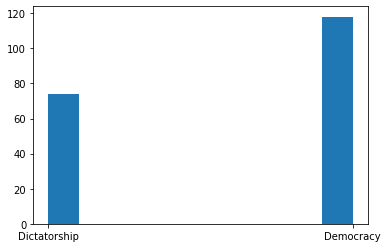

In [393]:
plt.hist(ddi_relevant_data['type'])
plt.rcParams["figure.figsize"] = (7,3)
plt.show()

In [394]:
fig = px.choropleth(
  ddi_relevant_data[['country_code', 'type']],
  locations='country_code',
  color='type',
  color_discrete_map={'Dictatorship':'Red','Democracy':'Green'},
  height=700
)

fig.update_layout(
  title_text=f'Map of Democracies countries vs Dictatorship countries',
)

fig.show()

we can see that at North and South America, Europe and Australia the Democracy is the majority while in Africa and Asia there are still many Dictatorships. 

# Analysis of Human Development Indices in Democracies vs Dictatorships

## compare democracy vs dictatorship countries

In [395]:
def plot_difference(data, indicator):
  labels = ['0']
  democracy_mean = round(data.loc[data['type'] == 'Democracy']['value'].mean(), 2)
  dictatorship_mean = round(data.loc[data['type'] == 'Dictatorship']['value'].mean(), 2)

  x = np.arange(len(labels))
  width = 0.1

  fig, ax = plt.subplots()
  ax.bar(x - width/2, democracy_mean, width, label='Democracy', color=['green'])
  ax.bar(x + width/2, dictatorship_mean, width, label='Dictatorship', color=['red'])

  ax.set_ylabel(f'{data["indicator_name"].iloc[0]} mean value (%)')
  ax.set_title(f'Compare {indicator} value between Democracy and Dictatorship countries')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.set_size_inches(8,5)
  fig.tight_layout()
  plt.show()

HDI mean value:
Democracies Countries: 0.71
Dictatorships Countries: 0.59



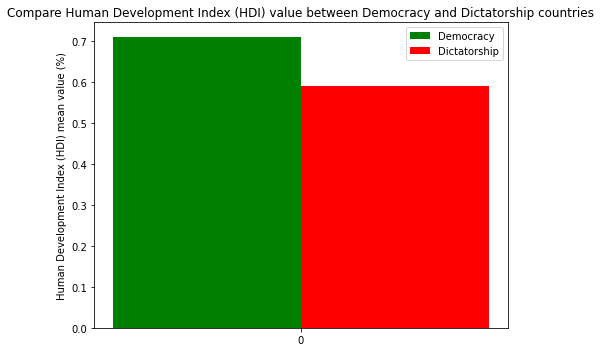

In [396]:
indicator = 'Human Development Index (HDI)'
hdi_indicator_data = demo_dict_data.loc[demo_dict_data['indicator_name'] == indicator].reset_index(drop=True)
hdi_democracy_mean = round(hdi_indicator_data.loc[hdi_indicator_data['type'] == 'Democracy']['value'].mean(), 2)
hdi_dictatorship_mean = round(hdi_indicator_data.loc[hdi_indicator_data['type'] == 'Dictatorship']['value'].mean(), 2)
print('HDI mean value:')
print(f'Democracies Countries: {hdi_democracy_mean}')
print(f'Dictatorships Countries: {hdi_dictatorship_mean}')
print('')
plot_difference(hdi_indicator_data, indicator)

We can see that Democracies countries have, in average, a better value in the Human Development Index.

GII mean value:
Democracies Countries: 0.32
Dictatorships Countries: 0.47



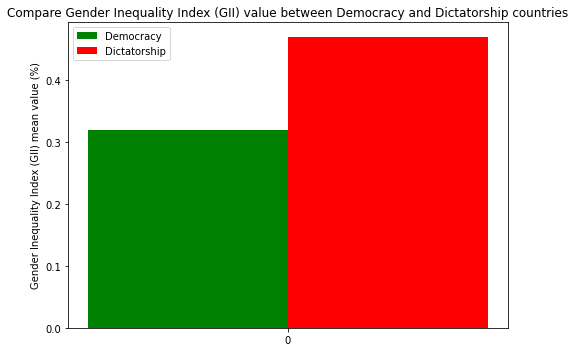

In [397]:
indicator = 'Gender Inequality Index (GII)'
gii_indicator_data = demo_dict_data.loc[demo_dict_data['indicator_name'] == indicator].reset_index(drop=True)
gii_democracy_mean = round(gii_indicator_data.loc[gii_indicator_data['type'] == 'Democracy']['value'].mean(), 2)
gii_dictatorship_mean = round(gii_indicator_data.loc[gii_indicator_data['type'] == 'Dictatorship']['value'].mean(), 2)
print('GII mean value:')
print(f'Democracies Countries: {gii_democracy_mean}')
print(f'Dictatorships Countries: {gii_dictatorship_mean}')
print('')
plot_difference(gii_indicator_data, indicator)

We can see that Democracies countries have, in average, a much better value in the Gender Inequality Index.

HDI mean value:
Democracies Countries: 7.37 %
Dictatorships Countries: 8.34 %



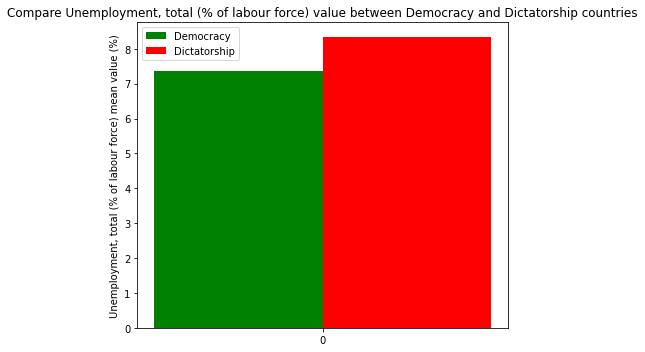

In [398]:
indicator = 'Unemployment, total (% of labour force)'
unemployment_indicator_data = demo_dict_data.loc[demo_dict_data['indicator_name'] == indicator].reset_index(drop=True)
unemployment_democracy_mean = round(unemployment_indicator_data.loc[unemployment_indicator_data['type'] == 'Democracy']['value'].mean(), 2)
unemployment_dictatorship_mean = round(unemployment_indicator_data.loc[unemployment_indicator_data['type'] == 'Dictatorship']['value'].mean(), 2)
print('HDI mean value:')
print(f'Democracies Countries: {unemployment_democracy_mean} %')
print(f'Dictatorships Countries: {unemployment_dictatorship_mean} %')
print('')
plot_difference(unemployment_indicator_data, indicator)

We can see that Democracies countries have, in average, slightly lower percentage of total unemployment.

Inequality in education mean value:
Democracies Countries: 16.65 %
Dictatorships Countries: 26.09 %



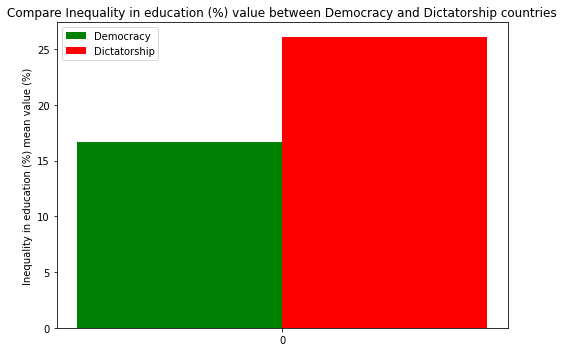

In [399]:
indicator = 'Inequality in education (%)'
education_inequality_indicator_data = demo_dict_data.loc[demo_dict_data['indicator_name'] == indicator].reset_index(drop=True)
education_inequality_democracy_mean = round(education_inequality_indicator_data.loc[education_inequality_indicator_data['type'] == 'Democracy']['value'].mean(), 2)
education_inequality_dictatorship_mean = round(education_inequality_indicator_data.loc[education_inequality_indicator_data['type'] == 'Dictatorship']['value'].mean(), 2)
print('Inequality in education mean value:')
print(f'Democracies Countries: {education_inequality_democracy_mean} %')
print(f'Dictatorships Countries: {education_inequality_dictatorship_mean} %')
print('')
plot_difference(education_inequality_indicator_data, indicator)

We can see that Democracies countries have, in average, much lower percentage of Inequality in Education.

Inequality in education mean value:
Democracies Countries: 22.91 %
Dictatorships Countries: 25.96 %



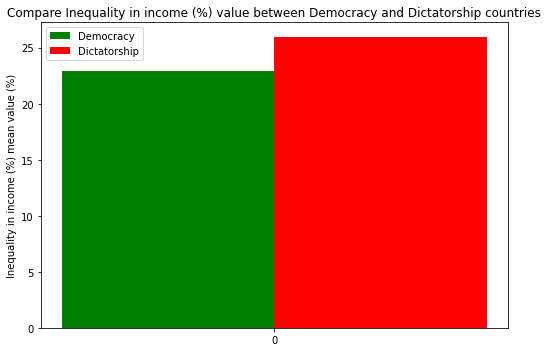

In [400]:
indicator = 'Inequality in income (%)'
income_inequality_indicator_data = demo_dict_data.loc[demo_dict_data['indicator_name'] == indicator].reset_index(drop=True)
income_inequality_democracy_mean = round(income_inequality_indicator_data.loc[income_inequality_indicator_data['type'] == 'Democracy']['value'].mean(), 2)
income_inequality_dictatorship_mean = round(income_inequality_indicator_data.loc[income_inequality_indicator_data['type'] == 'Dictatorship']['value'].mean(), 2)
print('Inequality in education mean value:')
print(f'Democracies Countries: {income_inequality_democracy_mean} %')
print(f'Dictatorships Countries: {income_inequality_dictatorship_mean} %')
print('')
plot_difference(income_inequality_indicator_data, indicator)

We can see that Democracies countries have, in average, slightly lower percentage of Inequality in Income.

# Amnesty International - Annual Report

## Download and load Amnesty reports file

In [401]:
!gdown --id 1--rT8XxWVjsRgSE0YdmnmhtirF3fA4S9

Downloading...
From: https://drive.google.com/uc?id=1--rT8XxWVjsRgSE0YdmnmhtirF3fA4S9
To: /content/amnesty_reports.csv
3.79MB [00:00, 59.7MB/s]


In [402]:
sframe = tc.SFrame.read_csv('/content/amnesty_reports.csv')

Finished parsing file /content/amnesty_reports.csv

Parsing completed. Parsed 100 lines in 0.122085 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/amnesty_reports.csv

Parsing completed. Parsed 426 lines in 0.090328 secs.

## Data Exploaration

### Word Cloud

In [403]:
data = sframe.to_dataframe()
lemmatizer = WordNetLemmatizer()

@lru_cache(maxsize=None)
def word_lemmatize(w):
    return lemmatizer.lemmatize(w)

def create_wordcloud(df,min_times=20):
  stopwords = set(STOPWORDS)
  words = []
  for val in df.text:
    val = str(val).lower()
    tokens = val.split()
    tokens_l = [word_lemmatize(t) for t in tokens]
    words.extend(tokens_l)
  wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10)
  def skip_entity(e):
    if e in stopwords or len(e)<3:
      return True
    return False
  c = Counter(words)
  # using the subject frquencies
  d = {k:v for k,v in dict(c).items() if v > min_times and not skip_entity(k)}
  wordcloud.generate_from_frequencies(d)
  plt.figure(figsize = (20, 20), facecolor = None) 
  plt.imshow(wordcloud)



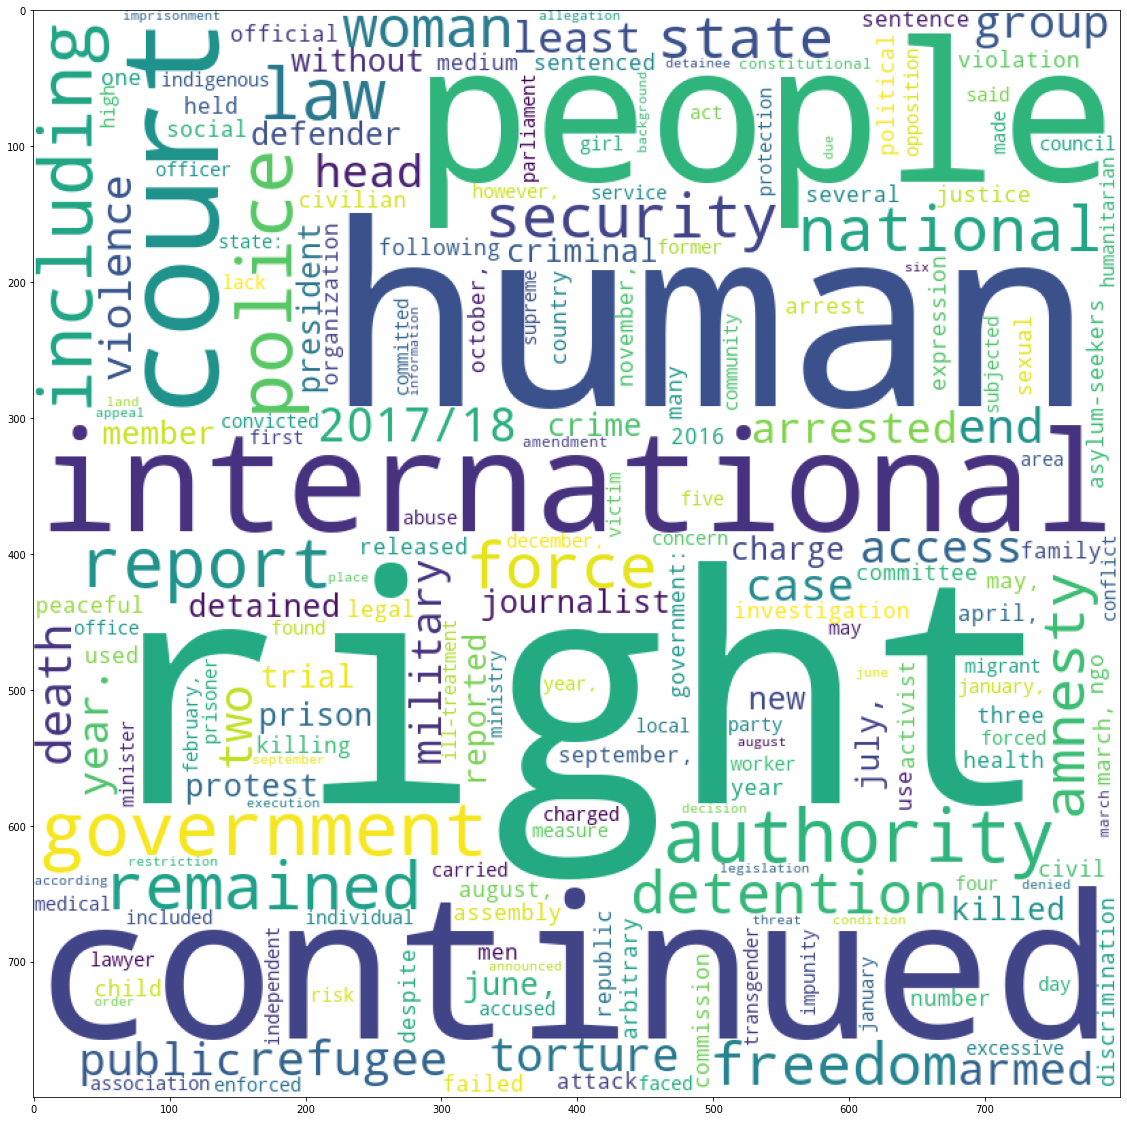

In [404]:
create_wordcloud(data[data['year']==2017])

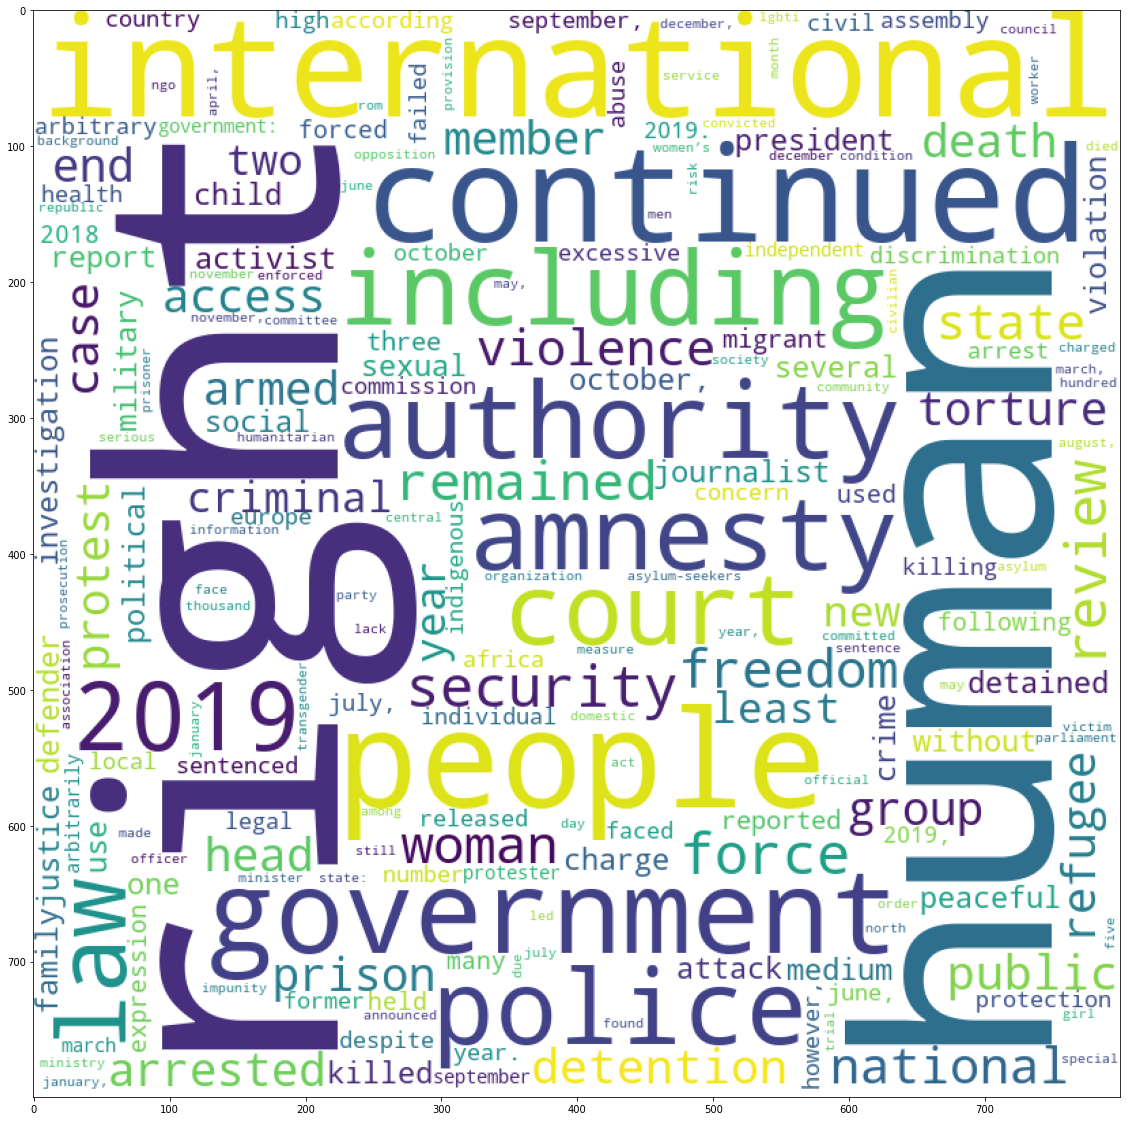

In [405]:
create_wordcloud(data[data['year']==2019])

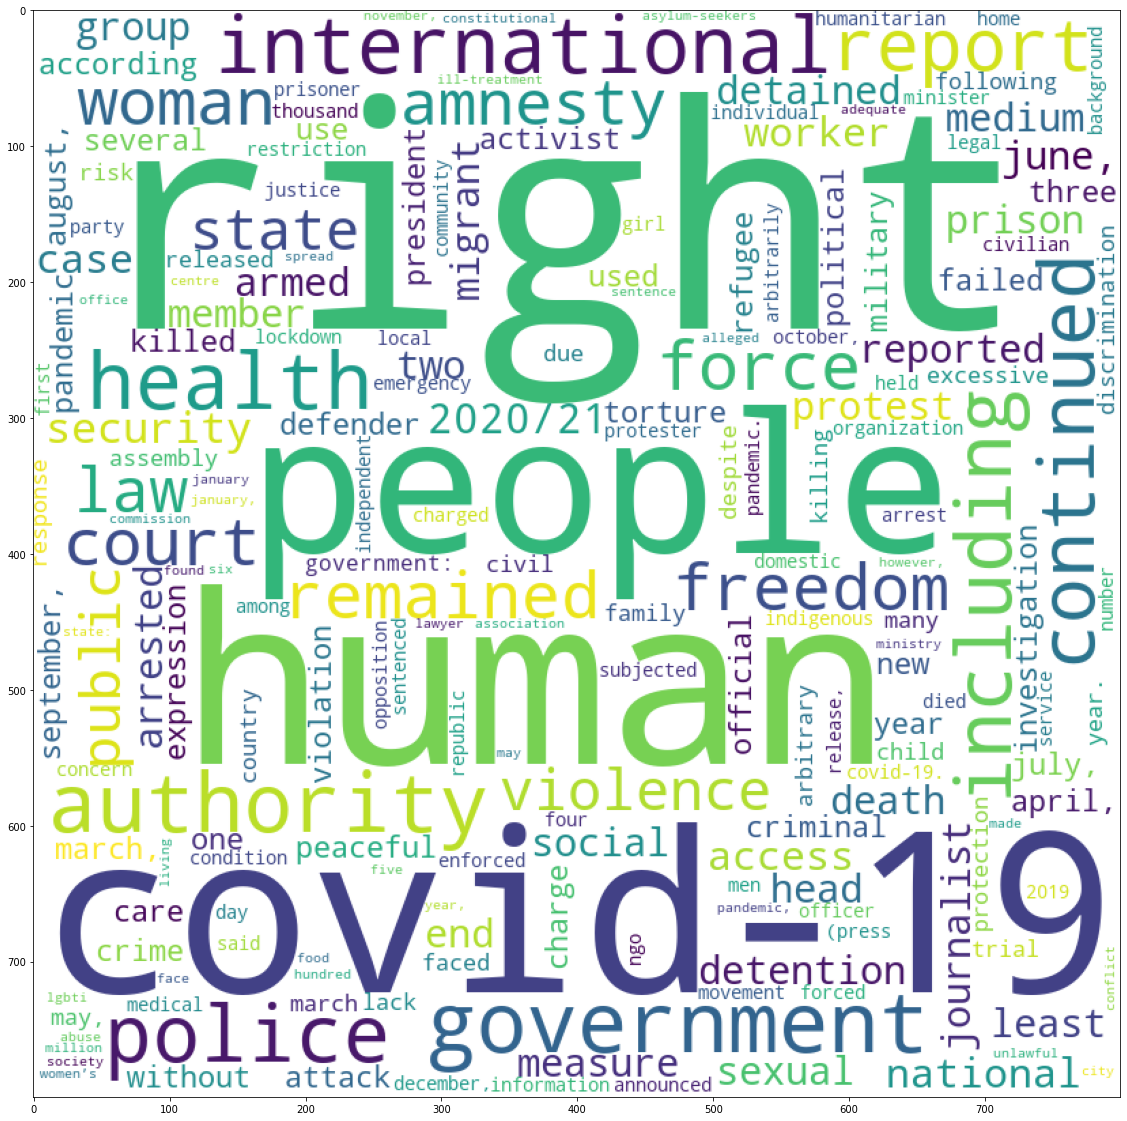

In [406]:
create_wordcloud(data[data['year']==2020])

### Sentiment Analysis

In [407]:
def textblob_func(text):
  blob_sentiment = TextBlob(text)
  return blob_sentiment.sentiment

def textblob_analysis(data):
  data['blob_sentiment'] = data['text'].apply(lambda r: textblob_func(r))
  data = data.unpack('blob_sentiment')
  data.materialize()
  return data

afinn = Afinn()
sframe['afinn_score'] = sframe['text'].apply(lambda t : afinn.score(t))

sframe = textblob_analysis(sframe)
sframe

Columns:
	country	str
	text	str
	year	int
	afinn_score	float
	blob_sentiment.0	float
	blob_sentiment.1	float

Rows: 426

Data:
+-----------------+-------------------------------+------+-------------+
|     country     |              text             | year | afinn_score |
+-----------------+-------------------------------+------+-------------+
|      china      | CHINA People’s Republic of... | 2020 |    -310.0   |
|    bangladesh   | BANGLADESH People’s Republ... | 2020 |    -177.0   |
|      cyprus     | CYPRUS Republic of Cyprus ... | 2020 |    -35.0    |
|    palestine    | PALESTINE (STATE OF) State... | 2020 |    -182.0   |
|  czech republic | CZECH REPUBLIC Czech Repub... | 2020 |    -51.0    |
|       oman      | OMAN Sultanate of Oman Hea... | 2020 |    -71.0    |
|      yemen      | YEMEN Republic of Yemen He... | 2020 |    -286.0   |
| north macedonia | NORTH MACEDONIA Republic o... | 2020 |    -77.0    |
|     belarus     | BELARUS Republic of Belaru... | 2020 |    -318.0   |
|     cambodia    | CAMBODIA Kingdom of Cambod... | 2020 |    -182.0   |
+-----------------+-------------------------------+------+-------------+
+-----------------------+---------------------+
|    blob_sentiment.0   |   blob_sentiment.1  |
+-----------------------+---------------------+
|  0.05082352577765421  |  0.3357688064568796 |
|  0.013846268501957117 | 0.33504573271040355 |
| -0.011097461097461098 | 0.34393939393939393 |
|  -0.01090282882735713 |  0.3795446037191319 |
| 0.0021011131725417486 | 0.30255530184101614 |
|  0.026600662711773828 |  0.3130578269467158 |
|  -0.04137007642563198 | 0.33519651541873785 |
|  -0.0791302235179786  |  0.3631195335276968 |
|  0.00211239377906044  | 0.37158659241992575 |
| -0.012596461509504992 | 0.35382787502352725 |
+-----------------------+---------------------+
[426 rows x 6 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

### Afinn score distribution per year

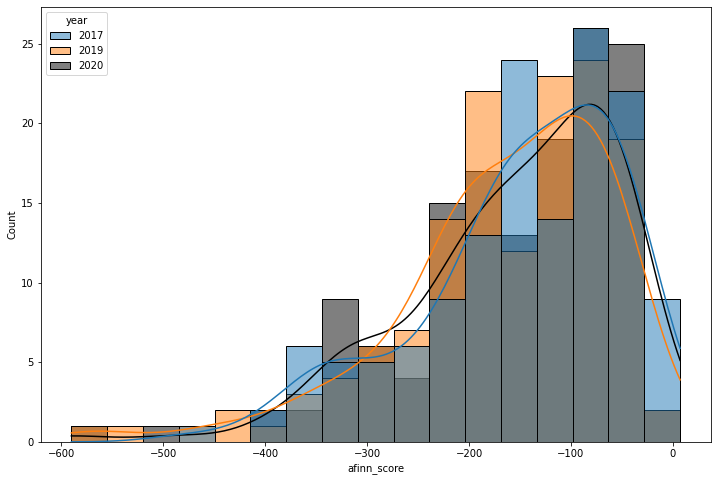

In [458]:
plt.figure(1,figsize=(12,8)) 
sns.histplot(sframe.to_dataframe(),x='afinn_score',hue='year',kde=True,palette=["C0", "C1", "k"])

### Afinn score top 10 best and worst countries

In [409]:
def plot_countries(df):
  years = df['year'].unique()
  data = pd.DataFrame()
  for year in years:
    data_by_year = df[df['year']==year]
    data_by_year = data_by_year.sort_values('afinn_score')
    worst_10_countries = data_by_year[:10]
    top_10_countries = data_by_year[-10:]
    data = data.append(worst_10_countries)
    data = data.append(top_10_countries)
  return data




In [410]:
data = plot_countries(sframe.to_dataframe())
fig = px.violin(data,y='afinn_score',color='year',hover_name='country',points='all')
fig.show()

### Word Embedding

In [411]:
def clean_text(text,words_to_remove):
  text = text.lower()
  clean_words = []
  remove_words = stop_words_set | set(words_to_remove)
  for word in word_tokenize(text):
    # keep only letters 
    word = re.sub('[^a-zA-Z]+',' ',word)
    stem_word = word_lemmatize(word)
    if len(word) < 2 or word in remove_words or stem_word in remove_words :
      continue
    clean_words.append(stem_word)
  text_clean = " ".join(clean_words)
  words_count = Counter(clean_words)
  return text_clean, words_count

def word_embedding(sframe,column_name):
  vectors = []
  for index in tqdm(range(len(sframe))):
    row_text = sframe[index][column_name]
    text_clean, words = clean_text(row_text,[])
    vectors.append(nlp(text_clean).vector)
  sframe['vector'] = vectors
  return sframe


In [412]:
def dimension_reduction(data):
  data['tsne'] = TSNE(n_components=2).fit_transform(data['vector'])
  data = data.unpack('tsne')
  return data

def scatter_plot(data,x,y,hover_data,color):
  fig = px.scatter(data, x=x, y=y ,hover_data = hover_data,color=color)
  fig.show()


In [413]:
data_amnesty = word_embedding(sframe.copy(),'text')
data_amnesty = dimension_reduction(data_amnesty)
scatter_plot(data_amnesty,'tsne.0','tsne.1',['country'],'year')

100%|██████████| 426/426 [01:10<00:00,  6.02it/s]


### Distance between the vector of each country over each two years 

In [414]:
def calculate_distance_between_years(sframedata):
  df = sframedata.to_dataframe()
  country_names = df['country'].unique()
  dist_17_19 = []
  dist_17_20 = []
  dist_19_20 = []
  for c in  country_names:
    c_data = df[df['country']==c]
    c_2017 = c_data[c_data['year']==2017]['vector'].iloc[0]
    c_2019 = c_data[c_data['year']==2019]['vector'].iloc[0]
    c_2020 = c_data[c_data['year']==2020]['vector'].iloc[0]
    dist_17_19.append(np.linalg.norm(c_2017-c_2019))
    dist_17_20.append(np.linalg.norm(c_2017-c_2020))
    dist_19_20.append(np.linalg.norm(c_2019-c_2020))

  dist_17_19 = tc.SFrame({'distance':dist_17_19})
  dist_17_19['year'] = '2017-2019'
  dist_17_19['country'] = country_names

  dist_17_20 = tc.SFrame({'distance':dist_17_20})
  dist_17_20['year'] = '2017-2020'
  dist_17_20['country'] = country_names

  dist_19_20 = tc.SFrame({'distance':dist_19_20})
  dist_19_20['year'] = '2019-2020'
  dist_19_20['country'] = country_names
  distance = tc.SFrame(dist_17_19)
  distance = distance.append(dist_17_20)
  distance = distance.append(dist_19_20)
  return distance

In [415]:
distance_over_years = calculate_distance_between_years(data_amnesty)

In [416]:
fig = px.violin(distance_over_years.to_dataframe(),y='distance',color='year',hover_data=['country'])
fig.show()

## clean text 

In [417]:
def words_count(sframe):
  words_dict = tc.text_analytics.count_words(sframe['text'])
  doc_counter = {}
  words_counter = {}
  for doc in words_dict:
    for word, count in doc.items():
      if word in words_counter.keys():
        words_counter[word] += count
      else:
        words_counter[word] = count
      if word in doc_counter.keys():
        doc_counter[word]+=1
      else:
        doc_counter[word] = 1
  return doc_counter, words_counter


def clean_text(text,words_to_remove):
  text = text.lower()
  clean_words = []
  remove_words = stop_words_set | set(words_to_remove)
  for word in word_tokenize(text):
    # keep only letters 
    word = re.sub('[^a-zA-Z]+',' ',word)
    stem_word = word_lemmatize(word)
    if len(word) < 2 or word in remove_words or stem_word in remove_words :
      continue
    clean_words.append(stem_word)
  text_clean = " ".join(clean_words)
  words_count = Counter(clean_words)
  return text_clean, words_count

def clean_data(data):
  doc_counter, words_counter = words_count(data)
  # remove words that are in more than 95% of the documents or less than 5 documents
  words_to_remove = [word for word, count in doc_counter.items() if count >= 0.95 * len(data) or count < 5]
  clean_texts = []
  bow = []
  for i in range(len(data)):
    row_text = data[i]['text']
    text_clean, count_words = clean_text(row_text,words_to_remove)
    clean_texts.append(text_clean)
    bow.append(count_words)
  data['bow'] = bow
  data['clean_text'] = clean_texts 
  return data

In [418]:
data_clean = tc.SFrame()
years = sframe['year'].unique()

for year in years:
  data = sframe[sframe['year']==year]
  data = clean_data(data)
  data_clean = data_clean.append(data)
sframe = data_clean
sframe

Columns:
	country	str
	text	str
	year	int
	afinn_score	float
	blob_sentiment.0	float
	blob_sentiment.1	float
	bow	list
	clean_text	str

Rows: 426

Data:
+----------+-------------------------------+------+-------------+
| country  |              text             | year | afinn_score |
+----------+-------------------------------+------+-------------+
| lesotho  | LESOTHO Kingdom of Lesotho... | 2017 |    -173.0   |
|  yemen   | YEMEN Republic of Yemen He... | 2017 |    -245.0   |
|  sudan   | SUDAN Republic of the Suda... | 2017 |    -139.0   |
| slovakia | SLOVAKIA Slovak Republic H... | 2017 |    -53.0    |
| croatia  | CROATIA Republic of Croati... | 2017 |    -92.0    |
| pakistan | PAKISTAN Islamic Republic ... | 2017 |    -206.0   |
|  poland  | POLAND Republic of Poland ... | 2017 |    -70.0    |
| paraguay | PARAGUAY Republic of Parag... | 2017 |    -79.0    |
| zimbabwe | ZIMBABWE Republic of Zimba... | 2017 |    -188.0   |
|   cuba   | CUBA Republic of Cuba Head... | 2017 |    -118.0   |
+----------+-------------------------------+------+-------------+
+-----------------------+---------------------+-------------------------------+
|    blob_sentiment.0   |   blob_sentiment.1  |              bow              |
+-----------------------+---------------------+-------------------------------+
|  -0.02207275311752924 | 0.27071105511404014 | [kingdom, king, iii, repla... |
|  0.016479892462035312 | 0.30776253178038904 | [yemen, republic, ahmed, b... |
|  -0.0481156501726122  |  0.2614167478091529 | [sudan, republic, omar, ha... |
| -0.007752211556559387 |  0.3385869565217391 | [republic, court, justice,... |
|  0.040499479423530056 |  0.3397651926132939 | [republic, grabar kitarovi... |
|  0.015104426478598665 | 0.27342032140045386 | [islamic, republic, replac... |
|  0.02547995482778091  | 0.33585988287075264 | [republic, replaced, szyd ... |
|  0.027448337825696317 | 0.37998652291105117 | [republic, indigenous, peo... |
| -0.031149681056223084 | 0.32820130544429604 | [republic, replaced, novem... |
|  0.04168672597244027  |  0.3027402755974184 | [republic, ra l, arbitrary... |
+-----------------------+---------------------+-------------------------------+
+-------------------------------+
|           clean_text          |
+-------------------------------+
| kingdom king iii replaced ... |
| yemen republic yemen ahmed... |
| sudan republic sudan omar ... |
| republic court justice eur... |
| republic grabar kitarovi  ... |
| islamic republic replaced ... |
| republic replaced szyd o d... |
| republic indigenous people... |
| republic replaced november... |
| republic ra l arbitrary de... |
+-------------------------------+
[426 rows x 8 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

## Word Embedding - clean text

In [419]:

# load one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/
# nlp = spacy_sentence_bert.load_model('en_stsb_roberta_large')

vectors = []
for index in tqdm(range(len(sframe))):
  row_text = sframe[index]['clean_text']
  vectors.append(nlp(row_text).vector)

sframe['vector'] = vectors
sframe

100%|██████████| 426/426 [00:49<00:00,  8.61it/s]


Columns:
	country	str
	text	str
	year	int
	afinn_score	float
	blob_sentiment.0	float
	blob_sentiment.1	float
	bow	list
	clean_text	str
	vector	ndarray

Rows: 426

Data:
+----------+-------------------------------+------+-------------+
| country  |              text             | year | afinn_score |
+----------+-------------------------------+------+-------------+
| lesotho  | LESOTHO Kingdom of Lesotho... | 2017 |    -173.0   |
|  yemen   | YEMEN Republic of Yemen He... | 2017 |    -245.0   |
|  sudan   | SUDAN Republic of the Suda... | 2017 |    -139.0   |
| slovakia | SLOVAKIA Slovak Republic H... | 2017 |    -53.0    |
| croatia  | CROATIA Republic of Croati... | 2017 |    -92.0    |
| pakistan | PAKISTAN Islamic Republic ... | 2017 |    -206.0   |
|  poland  | POLAND Republic of Poland ... | 2017 |    -70.0    |
| paraguay | PARAGUAY Republic of Parag... | 2017 |    -79.0    |
| zimbabwe | ZIMBABWE Republic of Zimba... | 2017 |    -188.0   |
|   cuba   | CUBA Republic of Cuba Head... | 2017 |    -118.0   |
+----------+-------------------------------+------+-------------+
+-----------------------+---------------------+-------------------------------+
|    blob_sentiment.0   |   blob_sentiment.1  |              bow              |
+-----------------------+---------------------+-------------------------------+
|  -0.02207275311752924 | 0.27071105511404014 | [kingdom, king, iii, repla... |
|  0.016479892462035312 | 0.30776253178038904 | [yemen, republic, ahmed, b... |
|  -0.0481156501726122  |  0.2614167478091529 | [sudan, republic, omar, ha... |
| -0.007752211556559387 |  0.3385869565217391 | [republic, court, justice,... |
|  0.040499479423530056 |  0.3397651926132939 | [republic, grabar kitarovi... |
|  0.015104426478598665 | 0.27342032140045386 | [islamic, republic, replac... |
|  0.02547995482778091  | 0.33585988287075264 | [republic, replaced, szyd ... |
|  0.027448337825696317 | 0.37998652291105117 | [republic, indigenous, peo... |
| -0.031149681056223084 | 0.32820130544429604 | [republic, replaced, novem... |
|  0.04168672597244027  |  0.3027402755974184 | [republic, ra l, arbitrary... |
+-----------------------+---------------------+-------------------------------+
+-------------------------------+-------------------------------+
|           clean_text          |             vector            |
+-------------------------------+-------------------------------+
| kingdom king iii replaced ... | [-1.16783634e-01  1.522969... |
| yemen republic yemen ahmed... | [-8.97767767e-02  2.775209... |
| sudan republic sudan omar ... | [-8.03342536e-02  5.527670... |
| republic court justice eur... | [-8.62590969e-02  9.319117... |
| republic grabar kitarovi  ... | [-4.11119349e-02  6.753294... |
| islamic republic replaced ... | [-1.04809009e-01  8.971866... |
| republic replaced szyd o d... | [-8.15708786e-02  6.427836... |
| republic indigenous people... | [-8.35702196e-02  7.397766... |
| republic replaced november... | [-8.96223560e-02  1.441513... |
| republic ra l arbitrary de... | [-1.08810067e-01  5.236091... |
+-------------------------------+-------------------------------+
[426 rows x 9 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

## Cluster countries

### Find best K - Silhouette method

In [420]:
def find_best_k_clustering(df,column_name='vector'):  

  sil = []
  kmax = 20
  for k in range(2, kmax+1):
    clusters = AgglomerativeClustering(k).fit(df[column_name])
    labels = clusters.labels_
    sil.append(silhouette_score(df['vector'], labels, metric = 'euclidean'))
  plt.plot(range(2,kmax+1), sil, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Silhouette Method')
  plt.show()

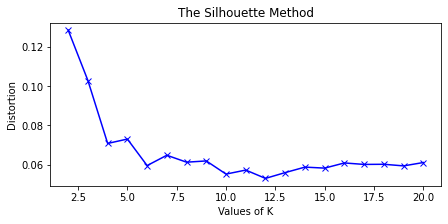

In [421]:
find_best_k_clustering(sframe[sframe['year']==2017])


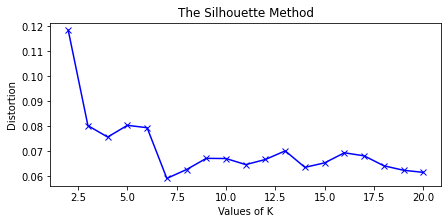

In [422]:
find_best_k_clustering(sframe[sframe['year']==2019])


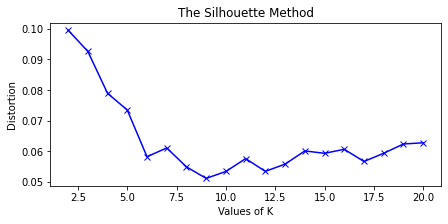

In [423]:
find_best_k_clustering(sframe[sframe['year']==2020])

### Cluster countries per year

In [424]:
def cluster_countires(data,k,column_name='vector'):
  cluster = AgglomerativeClustering(k).fit(data[column_name])
  data['cluster'] = cluster.labels_
  return data
  
def vector_tsne(data,d=2,column_name='vector'):
  data['tsne'] = TSNE(n_components=d).fit_transform(data[column_name])
  return data

def print_clusters(data,column_name='country'):
  clusters = data.groupby('cluster',{'countries':tc.aggregate.CONCAT(column_name)}).sort('cluster')
  for index in range(len(clusters)):
    print(str(clusters[index]['cluster']) + " : " + str(clusters[index]['countries']))


In [425]:
clustering_2017 = cluster_countires(sframe[sframe['year']==2017].copy(),5)
clustering_2017 = vector_tsne(clustering_2017[clustering_2017['year']==2017])


In [426]:
clustering_2019 = cluster_countires(sframe[sframe['year']==2019].copy(),5)
clustering_2019 = vector_tsne(clustering_2019 [clustering_2019 ['year']==2019])


In [427]:
clustering_2020 = cluster_countires(sframe[sframe['year']==2020].copy(),5)
clustering_2020 = vector_tsne(clustering_2020[clustering_2020['year']==2020])

### Scatter plot of TSNE on the embedded vector

In [428]:
print_clusters(clustering_2017)

0 : ['slovakia', 'croatia', 'poland', 'cuba', 'latvia', 'angola', 'qatar', 'japan', 'portugal', 'united states of america', 'finland', 'bolivia', 'belgium', 'germany', 'ghana', 'dominican republic', 'peru', 'ireland', 'guatemala', 'mongolia', 'tanzania', 'bosnia and herzegovina', 'nicaragua', 'uruguay', 'austria', 'puerto rico', 'canada', 'slovenia', 'bulgaria', 'nepal', 'czech republic', 'jordan', 'uganda', 'new zealand', 'benin', 'italy', 'lebanon', 'argentina', 'hungary', 'france', 'colombia', 'ecuador', 'moldova', 'united kingdom', 'romania', 'netherlands', 'switzerland', 'south korea', 'denmark', 'south africa', 'honduras']
1 : ['paraguay', 'russian', 'oman', 'taiwan', 'mexico', 'saudi arabia', 'uzbekistan', 'viet nam', 'bangladesh', 'algeria', 'thailand', 'united arab', 'turkmenistan', 'albania', 'tajikistan', 'el salvador', 'sweden', 'north macedonia', 'madagascar', 'kazakhstan', 'serbia', 'singapore', 'montenegro', 'kyrgyzstan', 'morocco', 'bahrain', 'iran', 'malaysia', 'georgi

In [429]:
clustering_2017 = clustering_2017.unpack('tsne')
fig = px.scatter(clustering_2017, x='tsne.0', y='tsne.1',hover_data = ['country'],color='cluster')
fig.show()

In [430]:
print_clusters(clustering_2019)

0 : ['united states of america', 'dominican republic', 'tanzania', 'canada', 'sierra leone', 'uruguay', 'botswana', 'nepal', 'slovenia', 'switzerland', 'new zealand', 'denmark', 'taiwan', 'slovakia', 'spain', 'lithuania', 'belgium', 'china', 'kazakhstan', 'mongolia', 'austria', 'romania', 'latvia', 'armenia', 'croatia', 'finland', 'greece', 'hungary', 'india', 'ireland', 'japan', 'bulgaria', 'portugal', 'bosnia and herzegovina', 'estonia', 'south korea', 'poland', 'singapore', 'north macedonia', 'sri lanka', 'germany', 'sweden', 'czech republic', 'united kingdom', 'albania']
1 : ['south africa', 'honduras', 'madagascar', 'mozambique', 'angola', 'montenegro', 'italy', 'norway', 'australia', 'malta', 'cyprus', 'saudi arabia', 'qatar', 'israel', 'jordan', 'kuwait', 'united arab', 'lebanon', 'palestine', 'oman', 'bahrain']
2 : ['chad', 'ethiopia', 'ghana', 'mali', 'somalia', 'cameroon', 'burkina faso', 'bangladesh', 'papua new guinea', 'pakistan', 'libya', 'syria', 'iraq', 'yemen', 'south 

In [431]:
clustering_2019 = clustering_2019.unpack('tsne')
fig = px.scatter(clustering_2019, x='tsne.0', y='tsne.1',hover_data = ['country'],color='cluster')
fig.show()

In [432]:
print_clusters(clustering_2020)

0 : ['cambodia', 'chile', 'denmark', 'bulgaria', 'uzbekistan', 'ecuador', 'greece', 'venezuela', 'moldova', 'italy', 'dominican republic', 'portugal', 'south korea', 'france', 'ireland', 'netherlands', 'bolivia', 'belgium', 'indonesia', 'tajikistan', 'united kingdom', 'qatar', 'mongolia', 'ukraine', 'norway', 'nicaragua', 'japan', 'slovenia', 'finland', 'puerto rico', 'thailand', 'united states of america', 'paraguay', 'viet nam', 'bosnia and herzegovina', 'jordan', 'spain', 'croatia', 'sweden']
1 : ['bangladesh', 'yemen', 'central african republic', 'honduras', 'uruguay', 'guatemala', 'botswana', 'south africa', 'armenia', 'lesotho', 'peru', 'argentina', 'brazil', 'north korea', 'mozambique', 'ghana', 'georgia', 'congo democratic', 'afghanistan', 'myanmar', 'angola', 'colombia', 'papua new guinea', 'pakistan', 'south sudan', 'chad', 'somalia']
2 : ['china', 'oman', 'belarus', 'kyrgyzstan', 'united arab', 'uganda', 'turkey', 'burundi', 'egypt', 'serbia', 'malawi', 'turkmenistan', 'bahr

In [433]:
clustering_2020 = clustering_2020.unpack('tsne')
fig = px.scatter(clustering_2020, x='tsne.0', y='tsne.1',hover_data = ['country'],color='cluster')
fig.show()

### Choropleth - Countries clustering over the years



In [434]:
def create_choropleth_yearly_map(data, color,country='country_name',):
  fig = px.choropleth(
      data[[country, 'cluster', 'year']].sort_values(by=['year'], ascending=True),
      locations=country,
      color='cluster',
      color_continuous_scale=color,
      locationmode='country names',
      scope="world",
      animation_frame="year",
      animation_group=country,
      height=700
  )

  fig.update_layout(
      title_text='Countries clustering over the years'
  )

  fig.show()

clusters_over_years = tc.SFrame()
clusters_over_years = clusters_over_years.append(clustering_2017)
clusters_over_years = clusters_over_years.append(clustering_2019)
clusters_over_years = clusters_over_years.append(clustering_2020)
clusters_over_years['country'] = clusters_over_years['country'].apply(lambda s: s.capitalize())
create_choropleth_yearly_map(clusters_over_years.to_dataframe(),'rdylgn','country')

### Similarity between clusters over the years

In [435]:

def calculate_similarity_between_clusters(cluster1, cluster2):
  return adjusted_rand_score(cluster1,cluster2)

groups_2017 = clustering_2017.sort('country')['cluster']
groups_2019 = clustering_2019.sort('country')['cluster']
groups_2020 = clustering_2020.sort('country')['cluster']

In [436]:
similarity_2017_2019 = calculate_similarity_between_clusters(groups_2017,groups_2019)
similarity_2017_2020 = calculate_similarity_between_clusters(groups_2017,groups_2020)
similarity_2019_2020 = calculate_similarity_between_clusters(groups_2019,groups_2020)
print(f'Similarity between 2017-2019 - {similarity_2017_2019}')
print(f'Similarity between 2017-2020 - {similarity_2017_2020}')
print(f'Similarity between 2019-2020 - {similarity_2019_2020}')

Similarity between 2017-2019 - 0.1665863997727362
Similarity between 2017-2020 - 0.16314863300619653
Similarity between 2019-2020 - 0.1674031716072151


### Afinn score for each cluster

In [437]:
def plot_afinn_score_clustring(cluster, sframe):
  cluster = cluster.join(sframe, on=['country','year'])
  fig = px.box(cluster, y="afinn_score",color='cluster',points='all',hover_name='country')
  fig.show()

In [438]:
plot_afinn_score_clustring(clustering_2017,sframe)

In [439]:
plot_afinn_score_clustring(clustering_2019,sframe)

In [440]:
plot_afinn_score_clustring(clustering_2020,sframe)

## Graphs - networkx

In [441]:

def create_edges(countries):
  countries = sorted(countries)
  edges = []
  for i in range(len(countries)):
    for j in range(i+1,len(countries)):
      edges.append((countries[i],countries[j]))
  edges = tc.SFrame(edges)
  return edges


def create_data_to_graph(clusters_data):
  all_edges = tc.SFrame()
  clusters = clusters_data.groupby(['cluster','year'],{'countries':tc.aggregate.CONCAT('country')})
  for index in range(len(clusters)):
    edges = create_edges(clusters[index]['countries'])
    all_edges = all_edges.append(edges)
  all_edges = all_edges.unpack('X1')
  all_edges.rename({'X1.0':'From','X1.1':'To'},True)
  all_edges = all_edges.groupby(['From','To'],{'Weight':tc.aggregate.COUNT()}).sort('Weight',False)
  return all_edges

def create_nxgraph(edges):
  weights = edges['Weight'].unique().sort()
  nxgraph_dict ={}
  for w in weights:
    nxgraph = nx.Graph()
    edges_weight = edges[edges['Weight']==w]
    for i in range(len(edges_weight)):
      s = edges_weight[i]['From']
      t = edges_weight[i]['To']
      w = edges_weight[i]['Weight']
      nxgraph.add_edge(s,t,weight=w)
    nxgraph_dict[w] = nxgraph
  return nxgraph_dict

edges = create_data_to_graph(clusters_over_years)
nxgraph_dict = create_nxgraph(edges)


### Graph visualization

#### Graph weight 1

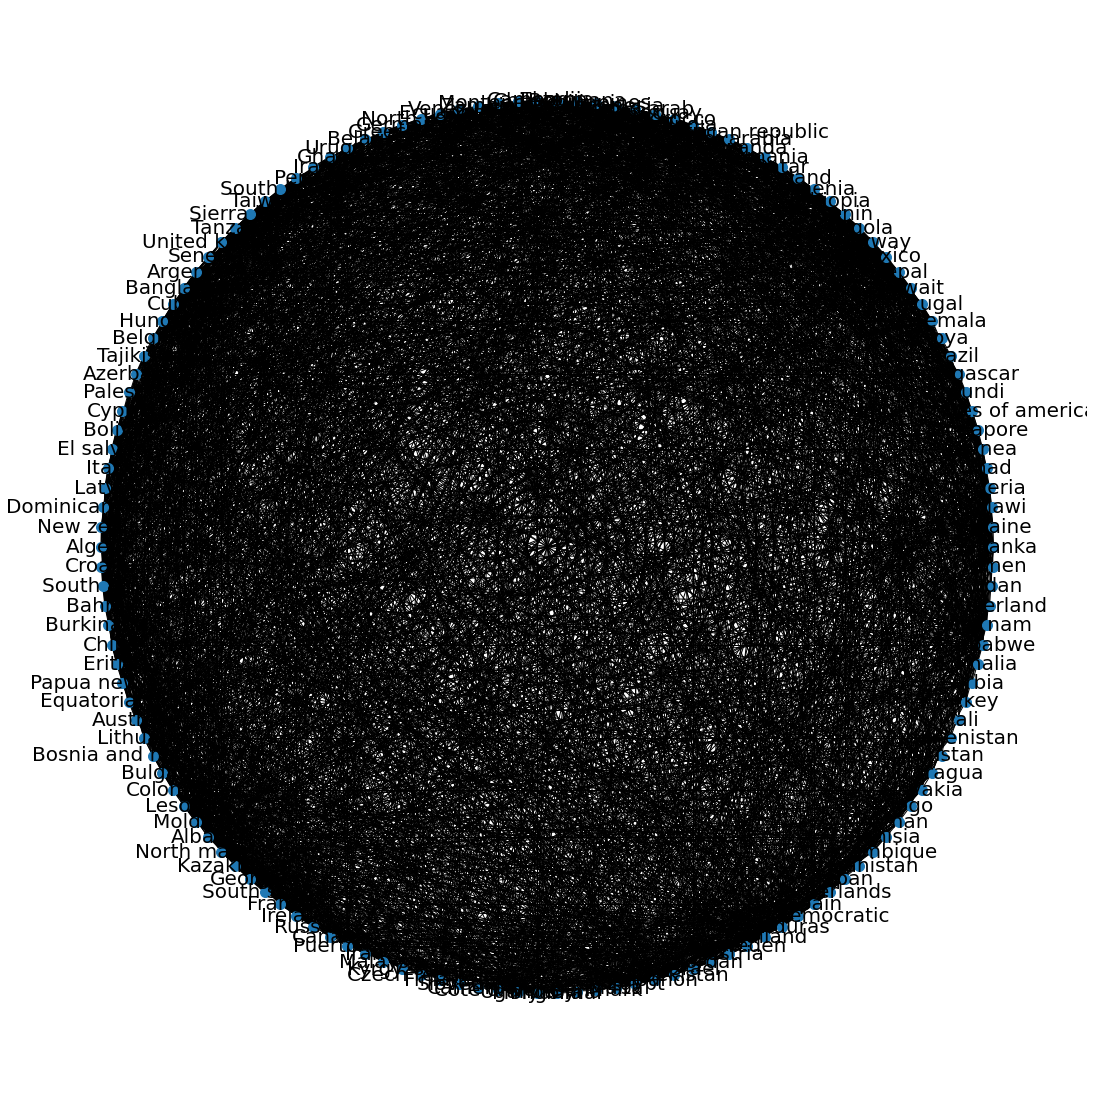

Graph with 142 nodes and 3084 edges


In [442]:
plt.figure(1,figsize=(15,15)) 
nx.draw_circular(nxgraph_dict[1],node_size=100,font_size=20,with_labels=True) 
plt.show()
print(nx.info(nxgraph_dict[1]))

#### Graph weight 2

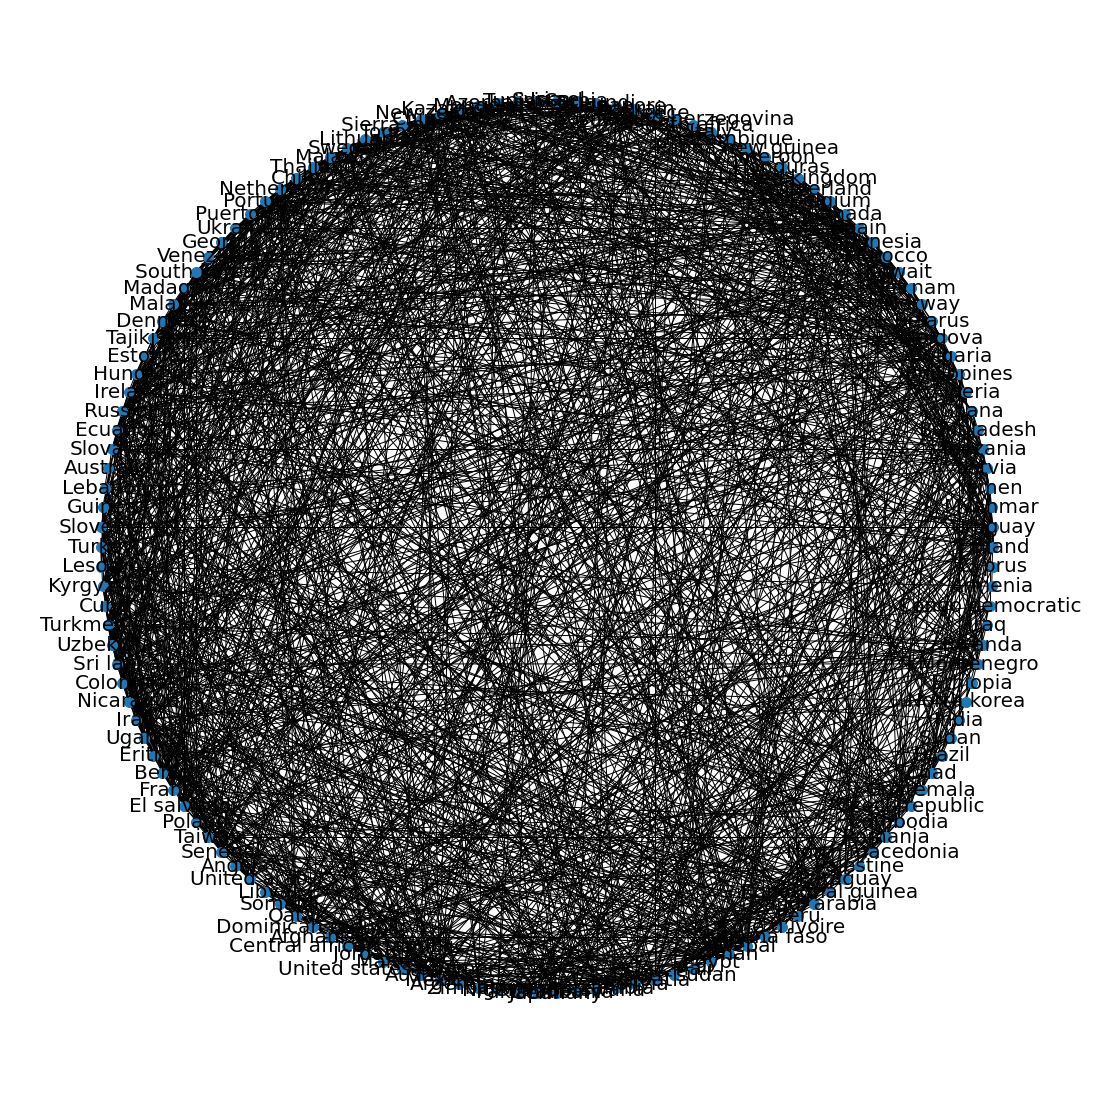

Graph with 142 nodes and 1525 edges


In [443]:
plt.figure(1,figsize=(15,15)) 
nx.draw_circular(nxgraph_dict[2],node_size=100,font_size=20,with_labels=True,) 
plt.show()
print(nx.info(nxgraph_dict[2]))

#### Graph weight 3

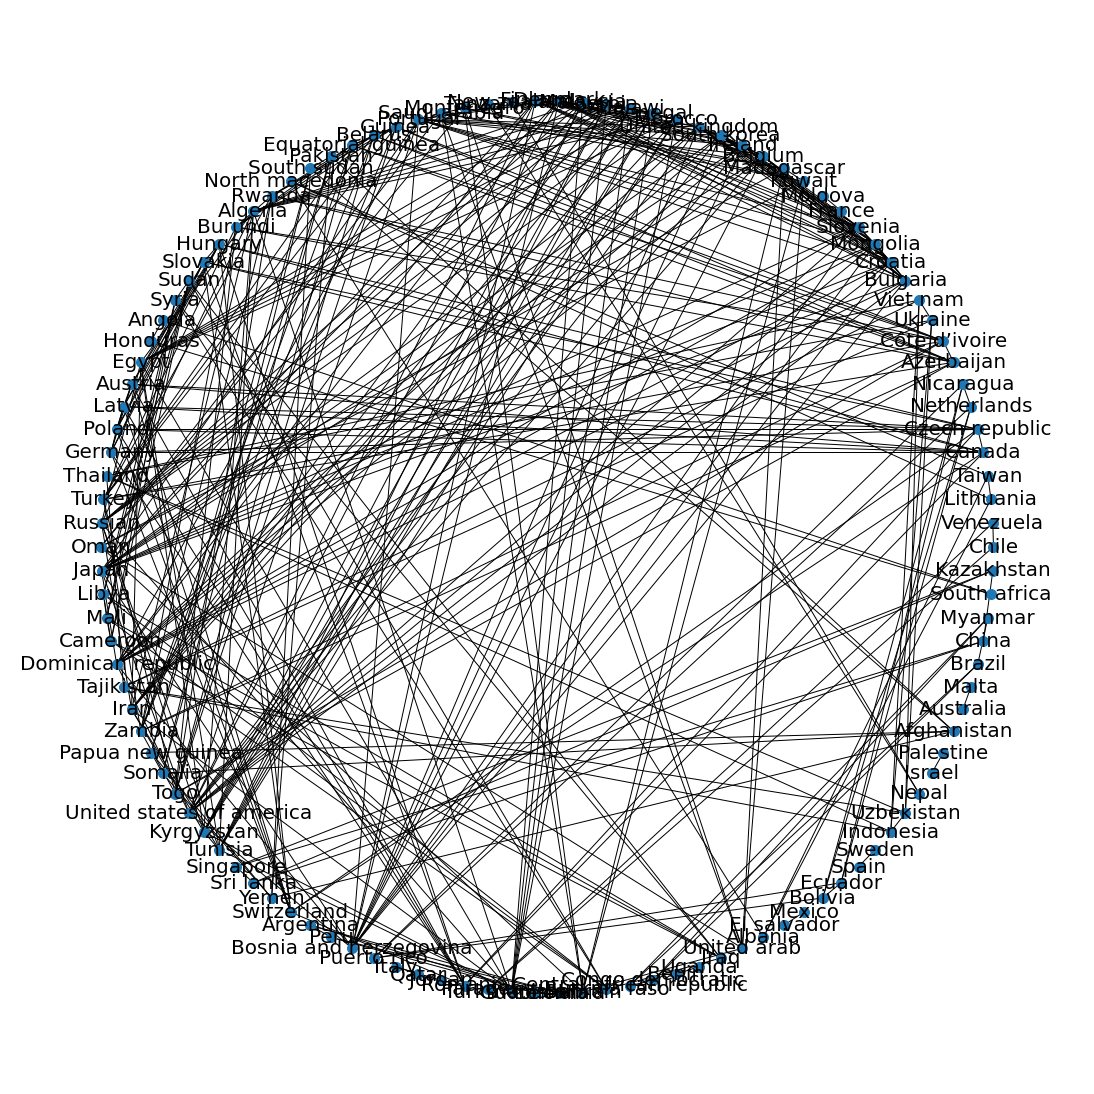

Graph with 118 nodes and 385 edges


In [444]:
plt.figure(1,figsize=(15,15)) 
nx.draw_circular(nxgraph_dict[3],node_size=100,font_size=20,with_labels=True,) 
plt.show()
print(nx.info(nxgraph_dict[3]))

In [476]:
cc = nx.connected_components(nxgraph_dict[3])
cc =sorted(cc,key=len)
counter = 0
connected_component = tc.SFrame()
countries = []
for c in cc :
  for country in c:
    countries.append((country,counter))
  counter+=1

connected_component['data'] = countries

connected_component = connected_component.unpack('data')

connected_component = connected_component.rename({'data.0':'country','data.1':'cluster'})
connected_component['year'] = '2020'
print_clusters(connected_component)
create_choropleth_yearly_map(connected_component.to_dataframe(),color='rdylgn',country='country')

0 : ['Moldova', 'France']
1 : ['Uganda', 'Benin']
2 : ['Mexico', 'El salvador']
3 : ['Spain', 'Sweden']
4 : ['Israel', 'Palestine']
5 : ['Australia', 'Malta']
6 : ['Chile', 'Paraguay', 'Venezuela']
7 : ['Tanzania', 'Nepal', 'New zealand']
8 : ['Honduras', 'Angola', 'South africa']
9 : ['Jordan', 'Qatar', 'Italy']
10 : ['North macedonia', 'Taiwan', 'Albania', 'Lithuania']
11 : ['Singapore', 'Sri lanka', 'Kazakhstan', 'China']
12 : ['Argentina', 'Guatemala', 'Peru', 'Colombia']
13 : ['Central african republic', 'Brazil', 'Congo democratic', 'Myanmar']
14 : ['Netherlands', 'Ecuador', 'Puerto rico', 'Bolivia', 'Nicaragua']
15 : ['Indonesia', 'Uzbekistan', 'Tajikistan', 'Ukraine', 'Thailand', 'Viet nam']
16 : ['Papua new guinea', 'South sudan', 'Yemen', 'Somalia', 'Afghanistan', 'Pakistan']
17 : ['Montenegro', 'United arab', 'Oman', 'Madagascar', 'Kuwait', 'Bahrain', 'Saudi arabia']
18 : ['Iraq', 'Cameroon', 'Syria', 'Sudan', 'Mali', 'Burkina faso', 'Libya']
19 : ['Poland', 'Slovakia', 'Ger

## cluster countries by indicators


In [445]:
hdi = tc.SFrame.read_csv('/content/hdi_dataset.csv')
hdi = hdi[['indicator_id','country_name','year','value']]

Finished parsing file /content/hdi_dataset.csv

Parsing completed. Parsed 100 lines in 1.15427 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/hdi_dataset.csv

Parsing completed. Parsed 282848 lines in 0.619992 secs.

In [446]:
def calculate_number_of_indicator(hdi):
  indicators = hdi.groupby('indicator_id',{'count':tc.aggregate.COUNT()}).sort('count',False)
  return indicators

def get_countries_vector(hdi):
  countries_vectors = hdi.groupby('country_name',{'vector':tc.aggregate.CONCAT('value')})
  countries_vectors['num_indicator'] = countries_vectors['vector'].apply(lambda v: len(v))
  countries_vectors = countries_vectors.sort('num_indicator',False)
  return countries_vectors


### Clustering year 2019

In [447]:
hdi_2019 = hdi[hdi['year'] == '2019']
indicators_2019 = calculate_number_of_indicator(hdi_2019)
# because the indicators are not the same to all countries we took only indicators that appears in more than 160 countries.
indicators_2019 = indicators_2019[indicators_2019['count'] >=160]
hdi_2019 = hdi_2019.filter_by(indicators_2019['indicator_id'],'indicator_id')

In [448]:
countries_vectors = hdi_2019.groupby('country_name',{'vector':tc.aggregate.CONCAT('value')})
countries_vectors['num_indicator'] = countries_vectors['vector'].apply(lambda v: len(v))
countries_vectors = countries_vectors.sort('num_indicator',False)
# we choose only the countries with max indicators,
# we need that each vector of indicators will be in the same size and contains the same indicators
countries_vectors = countries_vectors[countries_vectors['num_indicator']==59]
countries_vectors

Columns:
	country_name	str
	vector	array
	num_indicator	int

Rows: Unknown

Data:
+--------------+-------------------------------+---------------+
| country_name |             vector            | num_indicator |
+--------------+-------------------------------+---------------+
|    Rwanda    | [1876.241453, 2444.084852,... |       59      |
| Saudi Arabia | [1.767, 68.84821, 64.78652... |       59      |
|   Austria    | [39385.878, 73527.75415, 1... |       59      |
|   Burundi    | [865.8990802, 640.1050841,... |       59      |
|    Brazil    | [10534.70757, 18119.94376,... |       59      |
|    Malawi    | [838.2517663, 1236.624931,... |       59      |
|   Estonia    | [27086.33019, 45984.26715,... |       59      |
|  Montenegro  | [17517.90712, 25367.78748,... |       59      |
|    Zambia    | [3379.548659, 3270.421719,... |       59      |
|   Armenia    | [9737.422415, 18574.00572,... |       59      |
+--------------+-------------------------------+---------------+
[? rows x 3 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [449]:
cluster_2019 = cluster_countires(countries_vectors,5)
cluster_2019 = vector_tsne(cluster_2019)
cluster_2019 = cluster_2019.unpack('tsne')
cluster_2019['year'] = 2019
print_clusters(cluster_2019,'country_name')
fig = px.scatter(cluster_2019, x='tsne.0', y='tsne.1',hover_data = ['country_name'],color='cluster')
fig.show()

0 : ['Rwanda', 'Burundi', 'Brazil', 'Malawi', 'Montenegro', 'Zambia', 'Armenia', 'Bangladesh', 'Nepal', "Lao People's Democratic Republic", 'Mexico', 'Cambodia', 'Mozambique', 'Maldives', 'Bulgaria', 'Kenya', 'Uzbekistan', 'Belize', 'Kyrgyzstan', 'El Salvador', 'Mongolia', 'Bosnia and Herzegovina', 'Albania', 'Togo', 'Mauritania', 'Burkina Faso', 'Tanzania (United Republic of)', 'India', 'Namibia', 'Lesotho', 'South Africa', 'Afghanistan', 'Niger', 'Bolivia (Plurinational State of)', 'Tajikistan', 'Cabo Verde', 'Uruguay', 'Philippines', 'Iraq', 'China', 'Dominican Republic', 'Peru', 'Benin', 'Sierra Leone', 'Egypt', 'Barbados', 'Sao Tome and Principe', 'Ukraine', 'Argentina', 'Azerbaijan', 'North Macedonia', 'Costa Rica', 'Moldova (Republic of)', 'Guyana', 'Belarus', 'Slovenia', 'Mali', 'Ecuador', 'Honduras', 'Uganda', 'Eswatini (Kingdom of)', 'Tunisia', 'Nicaragua', 'Cameroon', 'Congo (Democratic Republic of the)', 'Lebanon', 'Zimbabwe', 'Kazakhstan', 'Sudan', 'Japan', 'Haiti', 'Pakis

### Clustering year 2018

In [450]:
hdi_2018 = hdi[hdi['year'] == '2018']
indicators_2018 = calculate_number_of_indicator(hdi_2018)
indicators_2018 = indicators_2018[indicators_2018['count'] >=160]
hdi_2018 = hdi_2018.filter_by(indicators_2018['indicator_id'],'indicator_id')
countries_vectors = hdi_2018.groupby('country_name',{'vector':tc.aggregate.CONCAT('value')})
countries_vectors['num_indicator'] = countries_vectors['vector'].apply(lambda v: len(v))
countries_vectors = countries_vectors.sort('num_indicator',False)
countries_vectors

Columns:
	country_name	str
	vector	array
	num_indicator	int

Rows: 195

Data:
+--------------+-------------------------------+---------------+
| country_name |             vector            | num_indicator |
+--------------+-------------------------------+---------------+
|    Zambia    | [14.3, 89.157, 44.34, 39.1... |       68      |
|     Togo     | [12.3602, 77.8861, 40.52, ... |       68      |
|   Ireland    | [84.5223, 103.171, 80.8184... |       68      |
| Saudi Arabia | [68.84821, 64.78652, 71.39... |       68      |
|   Austria    | [87.7105, 123.535, 100.0, ... |       68      |
|   Burundi    | [2.66075, 56.5347, 9.28, 7... |       68      |
|    Brazil    | [60.0145, 61.55127, 58.260... |       68      |
|    Malawi    | [13.7822, 39.0058, 21.76, ... |       68      |
|   Estonia    | [100.0, 100.0, 100.0, 13.4... |       68      |
|  Montenegro  | [71.5173, 180.694, 91.6185... |       68      |
+--------------+-------------------------------+---------------+
[195 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [451]:
countries_vectors = countries_vectors[countries_vectors['num_indicator']==68]
cluster_2018 = cluster_countires(countries_vectors,5)
cluster_2018 = vector_tsne(cluster_2018)
cluster_2018 = cluster_2018.unpack('tsne')
cluster_2018['year'] = 2018
print_clusters(cluster_2018,'country_name')
fig = px.scatter(cluster_2018, x='tsne.0', y='tsne.1',hover_data = ['country_name'],color='cluster')
fig.show()

0 : ['Zambia', 'Togo', 'Burundi', 'Brazil', 'Malawi', 'Montenegro', 'Turkey', 'Armenia', 'Rwanda', 'Bangladesh', 'Nepal', 'Mexico', 'Cambodia', 'Belize', 'Mali', 'New Zealand', 'Mozambique', 'Maldives', 'Bulgaria', 'Kenya', 'Uzbekistan', 'Indonesia', 'Kyrgyzstan', 'Oman', 'Russian Federation', 'Mongolia', 'Bosnia and Herzegovina', 'Albania', 'Mauritania', 'India', 'Bhutan', 'Namibia', 'Lesotho', 'South Africa', 'Niger', 'Bolivia (Plurinational State of)', 'Cabo Verde', 'Uruguay', 'Philippines', 'Iraq', 'China', 'Dominican Republic', 'Poland', 'El Salvador', 'Peru', 'Benin', 'Sierra Leone', 'Egypt', 'Barbados', 'Ukraine', 'Argentina', 'Azerbaijan', 'Costa Rica', 'Moldova (Republic of)', 'Guyana', 'Belarus', 'Paraguay', 'Haiti', 'Kazakhstan', 'Zimbabwe', 'Liberia', 'Israel', 'Ecuador', 'Pakistan', 'Uganda', 'Slovenia', 'Tonga', 'Colombia', 'Tunisia', 'Mauritius', 'Nicaragua', 'Sudan', 'Guatemala', 'Cameroon', 'Honduras', 'Eswatini (Kingdom of)', 'Lebanon', 'Japan', 'Myanmar', 'Panama', '

### Choropleth - Countries clustering over the years


In [452]:
hdi_over_years = tc.SFrame()
hdi_over_years = hdi_over_years.append(cluster_2018)
hdi_over_years = hdi_over_years.append(cluster_2019)
hdi_over_years['country_name'] = hdi_over_years['country_name'].apply(lambda s: s.capitalize())
create_choropleth_yearly_map(hdi_over_years.to_dataframe(),'rdylgn')